In [1]:
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
plt.rcParams['figure.dpi'] = 90
plt.rcParams['figure.figsize'] = (6, 5)

# Simple two-marginal problem

In [192]:
n = 30
m = 40

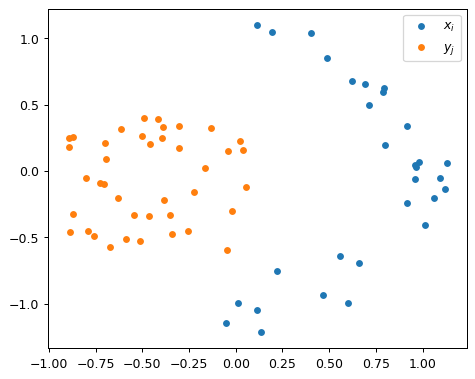

In [193]:
x = (np.random.rand(n) * 2 - 1) * 0.5 * np.pi
x = np.stack([np.cos(x), np.sin(x)], axis=1) + 0.1 * np.random.randn(n, 2)
y = np.random.rand(m, 2) - np.array([0.9, 0.6])

plt.scatter(*x.T, label="$x_i$", s=20)
plt.scatter(*y.T, label="$y_j$", s=20)
plt.legend()

The cost matrix is given by
\\[
    \mathbf{C}_{i,j} = |x_i - y_j|^2
\\]

Between the two datasets $X$ and $Y$, the Wasserstein distance is given by
$$
    \mathcal W_2^2(X,Y) = \min_{\mathbf{P}: \mathbf P^T\mathbf 1 = \mathbf a,\;\mathbf P\mathbf 1 = \mathbf b}~\langle \mathbf P,\mathbf C\rangle
$$

Here, the mass assigned to each point is identical. The obvious solution is taking the nearest-neighbor mapping between the points of $X$ and $Y$.

The Kantorovitch dual problem is given by
$$
    \max_{(\mathbf f,\mathbf g)\in R(\mathbf C)}~ \langle \mathbf f,\mathbf a\rangle+\langle\mathbf g,\mathbf b\rangle
$$
where $R(\mathbf C) = \{ \mathbf f,\mathbf g : \mathbf 1\mathbf f^T + \mathbf g \mathbf 1^T \leq \mathbf C \}$

In [194]:
from scipy.spatial import distance

In [195]:
# the distance matrix
pairwise_dists = np.square(distance.cdist(x, y, metric='euclidean'))

## Sinkhorn

Define the Gibbs matrix
$$
    \mathbf K_{i,j} = \exp(-\mathbf C_{i,j}/\epsilon)
$$

$$
    \mathbf u^{(n+1)} = \frac{\mathbf a}{\mathbf K\mathbf v^{(n)}},
    \quad
    \mathbf v^{(n+1)} = \frac{\mathbf b}{\mathbf K^T\mathbf u^{(n+1)}}
$$

In [196]:
def sinkhorn(a, b, K, n_iters=10, verbose='last'):
    # Initialize
    u = np.ones_like(a) / a.size
    v = np.ones_like(b) / b.size
    
    for i in range(n_iters):
        u_tmp = a / (K.dot(v))
        v_tmp = b / (np.dot(K.T, u_tmp))
        
        if (verbose=='last') and i+1==n_iters:
            du_norm = np.linalg.norm(u-u_tmp)
            dv_norm = np.linalg.norm(v-v_tmp)
            print("Rel. L2 improvement: u (%.3e); v (%.3e)"
                  % (du_norm/np.linalg.norm(u),
                     dv_norm/np.linalg.norm(v)))
        u = u_tmp
        v = v_tmp
    
    P = np.diag(u) @ K @ np.diag(v)
    return P, (u, v)

In [199]:
eps = 1e-2
cost_mat = pairwise_dists
K_mat = np.exp(-cost_mat / eps)

a_mes = np.ones(n) / n
b_mes = np.ones(m) / m

In [200]:
plan, _ = sinkhorn(a_mes, b_mes, K_mat, n_iters=100)

Rel. L2 improvement: u (3.835e-02); v (1.150e-01)


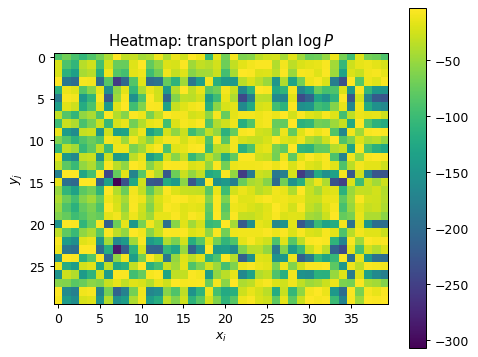

In [201]:
plt.imshow(np.log(plan), interpolation="nearest")
plt.xlabel("$x_i$")
plt.ylabel("$y_j$")
plt.title(r"Heatmap: transport plan $\log\,{P}$")
plt.colorbar()

Text(0.5, 1.0, 'Illustration of transport plan $P$')

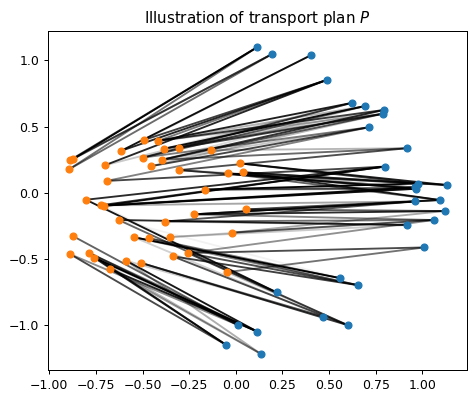

In [202]:
ot_max = plan.max()
threshold = 0.1 * ot_max

fig = plt.figure()

plt.scatter(*x.T, marker="o", s=30)
plt.scatter(*y.T, marker="o", s=30)

for i in range(plan.shape[0]):
    for j in range(plan.shape[1]):
        if plan[i, j] > threshold:
            alph = (plan[i, j] / threshold) ** 2
            plt.plot([x[i,0], y[j, 0]], [x[i,1], y[j, 1]],
                     color='black', zorder=-1,
                     alpha=alph)

plt.title("Illustration of transport plan $P$")